<a href="https://colab.research.google.com/github/AyushmaanAggarwal/Estimating-Edge-Effects-on-Parallel-Plate-Capacitor/blob/main/Estimate_Edge_Effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to the Edge Effects Model where you can get an approximate charge distribution on a square parallel plate capacitor.**

All you need to do is change the parameters using the sliders and number values and then press CTRL+F9(or Runtime -> Run All) in order to run all the code blocks and view the results at the bottom of the page.

The results will show the predicted capacitance, total time to run, and 2 color maps: 
- the first colormap is before trainning using a uniform charge density with the respective voltage drops across the plate
- the second colormap is after trainning showing the final charge distribution on the right and the respective voltage drops after training.

The voltage drops will not be exactly uniform after trainning because there is diminishing returns on running the program for longer to obtain a more uniform charge distribution, but note how the scale of the voltage drops decreases from before to after training by a sigificant amount.

If it takes too long to run, you can increase the percent of std to change the threshold which is considered an aceptable standard deviation of voltage drops across the plate.


If needed the charge distribution can be exported by looking at the cd.charge_dis array of values

In [ ]:
#@title Import Statments

import os
import csv
import time
import shelve
import numpy as np
from inspect import signature
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline


In [ ]:
# Constants
e_0 = 8.8541878128*(10**(0 - 12))
k_cons = 1/(4*np.pi*e_0)

In [52]:
#@title Paramters

#@markdown This parameter is the length of the square parallel plate capacitor
side_of_plate = 1 #@param {type:"number"}
s = side_of_plate

#@markdown This parameter allows you to control how far the dieletric is inserted into the parallel plate
insert_depth = 0 #@param {type:"number"}

#@markdown This parameter allows you to control the seperation between the parallel plates
plate_seperation = .1 #@param {type:"number"}
z_depth = plate_seperation

#@markdown This parameter allows you to control how thick the dieletric material is
thickness_of_dieletric_plate = .1 #@param {type:"number"}
dielectric_depth = thickness_of_dieletric_plate if z_depth != thickness_of_dieletric_plate else thickness_of_dieletric_plate*.99

#@markdown This parameter allows you to control the dieletric constant of the material(CANNOT BE 0)
kappa = 1 #@param {type:"number"}

#@markdown This parameter allows you to control how uniform you want the final plate as a percentage of the initial voltage drop of the plate(higher is less precise)
#@markdown WARNING: THIS WILL SIGIFICANTLY INCREASE THE AMOUNT OF COMPUTATION
percent_of_std = .005 #@param {type:"number", min:0, max:1}

In [53]:
#@title Various Functions
def range_func(lower, upper, step):
    """
    Similar to the range function inbuilt into python except this range function 
    can deal with integer values
    """
    while lower < upper:
        yield lower
        lower += step

def progress_bar(percent):
    """
    Progress bar using the percent of the progress
    """
    bar_len = 5
    n = int(percent*100//bar_len)
    p = int(percent*100//1)
    print("\r["+("="*n + " "*int((100//bar_len)-n))+"] "+str(p)+"%",end=" ")

def print_matrix(m):
    """
    Print matrix function as equally seperated values by spaces
    """
    if isinstance(m[0], list):
        return
    for i in range(len(m)):
        string = ""
        for j in range(len(m)):
            string += m[i][j]+ " "
        print(string)
    return

In [54]:
#@title Integral Estimater
bounds = {}
def estimate_integral_multivar(f, low_bounds, high_bounds, N):
    """
    Use the formula: Integral of function is ~ (b-a)*(1/N)*(sum of applying f to n steps between a and b)
    """
    arguments_f = len(signature(f).parameters)
    length = len(low_bounds)
    
    assert length == len(high_bounds) and length == arguments_f
    
    if low_bounds==high_bounds:
        return 0
    
    # Check if the bound values have already been calculated and are stored in dictionary
    if f"{low_bounds}-{high_bounds}-{N}" in bounds.keys():
        diff, size_of_steps, steps_lst = bounds[f"{low_bounds}-{high_bounds}-{N}"]
    else:
        diff = [ high_bounds[i] - low_bounds[i] for i in range(length) ]
        size_of_steps = [ b_a / N for b_a in diff]
        steps_lst = [list(range_func(low_bounds[i]+(size_of_steps[i]/2), high_bounds[i], size_of_steps[i])) for i in range(length)]
        bounds[f"{low_bounds}-{high_bounds}-{N}"] = diff, size_of_steps, steps_lst 
    

    def integrate_helper(total_args, var=[]):
        total = 0
        # If we reached the final step of integration, integrate using function f
        if len(var) == total_args-1:
            for step in steps_lst[len(var)]:
                temp_var = [step] + var
                total += f(*temp_var)
        else:
            # If not at final integral in the multiple integral steps, just recurse
            # to integrate each integral for each step in the outside integral
            for step in steps_lst[len(var)]:
                total += integrate_helper(total_args, [step]+var)

        integration_total = diff[len(var)]*total/N
        return integration_total
            
    return integrate_helper(arguments_f, [])


In [55]:
#@title Eletric Field Calculator

def dE_z(x,y,z, charge):
    """
    Calculate the electric field from a source charge at position (x, y z)
    """
    r = (x**2 + y**2 + z**2)**.5
    cos_gamma = z/r
    return k_cons*(charge/(r**2))*cos_gamma#*np.cos(gamma)

def E_z(x,y,z,surface_charge, eletric_field_res):
    """
    Integrate the electric field to measure total electric field from an s by s plate measured from (x, y z)
    """
    function_xy = lambda x_s,y_s: dE_z(x-x_s, y-y_s, z, surface_charge(x_s, y_s))
    return estimate_integral_multivar(function_xy, [0, 0], [s, s], eletric_field_res)

In [56]:
#@title Voltage Drop Calculator

charge_pos_dic = {}
def voltage_drop_with_dieletric(charge_distribution, insert_depth, k, z_depth, z_res, dieletric_depth, res=15, eletric_field_res=20):
    assert z_depth >= dieletric_depth
    assert k >= 1
    
    data = []
    
    # x1 repersents where the dieletric is inserted
    # x2 repersents all x values where there is no dielectric
    # y is the other axis perpendicular to the axis of insertion
    pos_of_chargesx1 = list(range_func((s/(2*res)),              insert_depth, s/res))
    pos_of_chargesx2 = list(range_func(insert_depth+(s/(2*res)), s,            s/res))
    pos_of_chargesy  = list(range_func((s/(2*res)),              s,            s/res))
    for x in pos_of_chargesx1:
        rows = []
        for y in pos_of_chargesy:
            # estimate the integral for the top and bottom metal parallel plates
            curry_E_z = lambda z: E_z(x,y,z, charge_distribution, eletric_field_res)
            in_dieletric_bot  = (1/k)*estimate_integral_multivar(curry_E_z, [0],[dieletric_depth],z_res)
            after_dieletric_bot = estimate_integral_multivar(curry_E_z, [dieletric_depth],[z_depth],z_res)
            in_dieletric_top  = (1/k)*estimate_integral_multivar(curry_E_z, [z_depth-dieletric_depth],[z_depth],z_res)
            before_dieletric_top = estimate_integral_multivar(curry_E_z, [0],[z_depth-dieletric_depth],z_res)
            
            # Make sure that all the values of the inverses of each voltage drop is non zero
            in_dieletric_bot = 0 if in_dieletric_bot==0 else 1/in_dieletric_bot
            after_dieletric_bot = 0 if after_dieletric_bot==0 else 1/after_dieletric_bot
            in_dieletric_top = 0 if in_dieletric_top==0 else 1/in_dieletric_top
            before_dieletric_top = 0 if before_dieletric_top==0 else 1/before_dieletric_top

            # Add the voltage drop to the array used to calculate the final charge distribution
            average_voltage_drop = (1/(in_dieletric_bot + after_dieletric_bot) + 1/(in_dieletric_top + before_dieletric_top))/2
            rows.append(average_voltage_drop)
        data.append(rows)

    # Integrate for all the positions where there is no dieletric materials
    for x in pos_of_chargesx2:
        rows = []
        for y in pos_of_chargesy:
            curry_E_z = lambda z: E_z(x,y,z, charge_distribution, eletric_field_res)
            voltage_drop = estimate_integral_multivar(curry_E_z, [0],[z_depth],z_res)
            rows.append(voltage_drop)
        data.append(rows)
    return data
    

In [57]:
#@title Charge Distribution - Object that can be modified and measured
class charge_distribution:
    def __init__(self, length=s, res=20):
        # Position of charges is a list which can be used to find location of each position of charge in space 
        # Charge distribution is an array repersenting the relative charge on a plate
        # Change the renormalization factor every 10 cycles by using the renormalize_counter
        midpoint = (s/res)/2
        self.pos_of_charges = list(np.round(list(range_func(0+midpoint, s, s/res)), 4))
        self.charge_dis = np.ones((res, res))
        self.renormalize_counter = 0
        
    def closest_point(self, x, y):
        # Find the location of the closest charge in the plates
        len_of_pos = lambda: range(len(self.pos_of_charges))
        x_pos = min(len_of_pos(), key=lambda loc: abs(self.pos_of_charges[loc]-x))
        y_pos = min(len_of_pos(), key=lambda loc: abs(self.pos_of_charges[loc]-y))
        return x_pos, y_pos
    
    def get_surface_charge(self, x,y):
        # Return the charge in the location x, y
        x_index, y_index = self.closest_point(x, y)
        return self.charge_dis[x_index][y_index]
    
    def normalized_matrix(self, matrix, alpha):
        # Renormalize the charge distribution from -1 to 1 so we can use it for 
        # learning and reforming the charge distribution 
        if self.renormalize_counter%10 == 0:
            self.max_val = max([max(row) for row in matrix])
            self.min_val = min([min(row) for row in matrix])
            self.diff = self.max_val - self.min_val
        norm_matrix = [[(val-self.min_val)/self.diff for val in row] for row in matrix]
        norm_matrix_1_to_neg_1 = [[(2*val - 1)*alpha for val in row] for row in norm_matrix]
        return norm_matrix_1_to_neg_1
    
    def change_surface_charge(self, data, alpha=.0002):
        # Change the charge distribution according to the voltage data by the learning rate
        assert len(data) == len(self.charge_dis)
        assert len(data[0]) == len(self.charge_dis[0])
        error = self.calculate_error(data)
        data = self.normalized_matrix(data, alpha)
        for i in range(len(data)):
            for j in range(len(data[0])):
                self.charge_dis[i][j] -= data[i][j]
        
        return error
    
    def calculate_error(self, data):
        # Error is repersented by the standard deviation of the list of charges
        long_lst = []
        for row in data:
            long_lst.extend(row)
        return np.std(long_lst)

In [58]:
#@title Capacitance Calculator
def calculate_capacitance(voltage, charge):
    Total_Voltage_from_one_plate = sum([sum(row) for row in voltage])/(len(voltage)*len(voltage[0]))
    Total_Charge = sum([sum(row) for row in charge])/(len(charge)*len(charge[0]))
    #print(Total_Voltage_from_one_plate*2, Total_Charge)
    return Total_Charge/(Total_Voltage_from_one_plate*2)

In [59]:
#@title Plot Data using Color Plot
def color_plot(data, charge_dis):
    cmap= cm.get_cmap('cividis', 256)    
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(14,5))
    
    ax0.set_title("Voltage Drop Graph")
    psm0 = ax0.pcolormesh(data, cmap=cmap, rasterized=True)
    fig.colorbar(psm0, ax=ax0)
    ax0.set_aspect('equal')
    ax1.set_title("Charge Distribution Graph")
    psm1 = ax1.pcolormesh(charge_dis, cmap=cmap, rasterized=True)
    fig.colorbar(psm1, ax=ax1)
    ax1.set_aspect('equal')

    plt.show()

Saving the charge distribution and data to a file

In [60]:
#@title Saving the file using shelve(Not needed to run applet)
def save_file(matrix, label):
    with shelve.open("shelf_files") as shfile:
        shfile[label]= matrix
        
def open_matrix(label):
    with shelve.open("shelf_files") as shfile:
        matrix = shfile[label]
    return matrix

def check_labels():
    with shelve.open("shelf_files") as shfile:
        keys = list(shfile.keys())
    return keys

In [61]:
#@title Save a dictionary that contains useful information(Not needed to run applet)
def checkpoint_charges(name, cd, plate_res, eletric_field_res, z_res, data, alpha, kappa):
    dic = {
        "charge_dis":cd,
        "resolution":(plate_res, eletric_field_res, z_res),
        "voltages":data,
        "alpha":alpha,
        "kappa":kappa,
        "capacitance":calculate_capacitance(data, cd.charge_dis)
    }
    save_file(dic, name)

def open_checkpoint(name, plot=True):
    print(name)
    dic = open_matrix(name)
    
    cd = dic["charge_dis"]
    res = dic["resolution"]
    data = dic["voltages"]
    try:
        alpha = dic["alpha"]
        kappa = dic["kappa"]
        capacitance = dic["capacitance"]
        print(f"Capacitance: {capacitance}")
    except:
        alpha = None
        kappa = None
        capacitance = None
    
    if plot:
        color_plot(data,cd.charge_dis)
        
        
    return cd, res, data, capacitance, alpha, kappa

Main Code

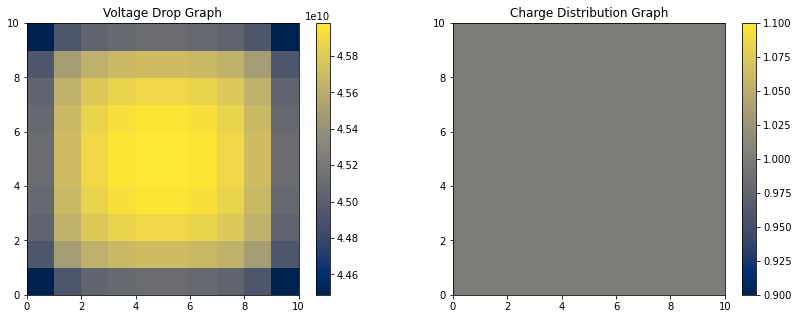

The progress bar is a ROUGH estimate assuming a dieletric insertion of 50% of size of plate and percent of std of 0.005
[==================  ] 91% Done with training: Reduced STD in Voltage by 0.33% 



Time Elapsed (sec): 16.214744806289673
Approximate Predicted Capacitance: 1.0990846000546396e-11


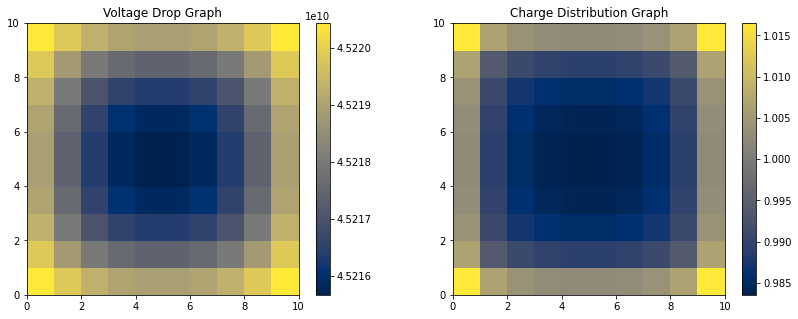

In [62]:
#@title MAIN CODE 

initial_time = time.time()
error_lst = []
plate_res, eletric_field_res, z_res = 10, 10, 10
cd = charge_distribution(s, plate_res)
alpha = .011

# Get First Plot 
data = voltage_drop_with_dieletric(cd.get_surface_charge, insert_depth=insert_depth, k=kappa, z_depth=z_depth, z_res=z_res, 
                                    dieletric_depth=dielectric_depth, res=plate_res, eletric_field_res=eletric_field_res)
color_plot(data, cd.charge_dis)

print("The progress bar is a ROUGH estimate assuming a dieletric insertion of 50% of size of plate and percent of std of 0.005")
percent_error = 1
for i in range(100):
    data = voltage_drop_with_dieletric(cd.get_surface_charge, insert_depth=insert_depth, k=kappa, z_depth=z_depth, z_res=z_res, 
                                        dieletric_depth=dielectric_depth, res=plate_res, eletric_field_res=eletric_field_res)
    error_lst.append(cd.change_surface_charge(data, alpha))
    old_percent_error = percent_error
    percent_error = np.round(error_lst[-1]/error_lst[0], 4)
    #print(i, percent_error)
    #if i%10 == 0 and i > 1:
    #   percent_error = np.round(error_lst[-1]/error_lst[0], 4)
    #    print("Time Elapsed (sec): "+str(time.time()-initial_time))
    #    print(i, percent_error)
    #    print(f"Current Approximate Capacitance: {calculate_capacitance(data, cd.charge_dis)}")
    #    color_plot(data, cd.charge_dis)
    progress_bar(i/12)
    if percent_error < percent_of_std:
        print(f"Done with training: Reduced STD in Voltage by {percent_error*100}% ")
        break
    if percent_error >= old_percent_error:
        alpha = alpha/2
    elif percent_error > old_percent_error*.95:
        alpha = alpha*2
print("")
print("\n\nTime Elapsed (sec): "+str(time.time()-initial_time))
print(f"Approximate Predicted Capacitance: {calculate_capacitance(data, cd.charge_dis)}")
color_plot(data, cd.charge_dis)

#name = f"charge_distribution insert: {insert_depth} k: {kappa} di-depth: {dielectric_depth} z depth: {z_depth}"
#checkpoint_charges(name, cd, plate_res, eletric_field_res, z_res, data, alpha, kappa)

#print(f"Current Approximate Capacitance: {calculate_capacitance(data, cd.charge_dis)}")
#color_plot(data, cd.charge_dis)